In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


def mock(num=10, size=10, seed=None):
    "return dataframe of simulated objects"
    if seed is not None:
        np.random.seed(seed)
    obj = np.random.random(size=(num, 3))
    obj[:, 0:2] *= size
    obj[:, 1] -= size / 2  # The location is scaled to simulate objects on a 10x10 grid.
    # objid = np.arange(obj.shape[0]) # object id
    df = pd.DataFrame(obj, columns=["x", "y", "u"])
    return df


def cat(mdf):
    "return simulated catalog and selection"
    sigma = 1 / 100 * np.random.randint(4, 10, (mdf.shape[0], 1))
    det = mdf.values[:, :2] + sigma * np.random.randn(mdf.shape[0], 2)
    df = pd.DataFrame(det, columns=["x", "y"])
    df["Sigma"] = sigma
    a, b = (0, 1)
    sel = np.logical_and(mdf.u >= a, mdf.u < b)
    # df['selected'] = np.array(sel, dtype=np.bool)
    return df.values, sel


def random_cat(mdf):
    "return simulated catalog with random selection intervals"
    sigma = 1 / 100 * np.random.randint(4, 10, (mdf.shape[0], 1))
    det = mdf.values[:, :2] + sigma * np.random.randn(mdf.shape[0], 2)
    df = pd.DataFrame(det, columns=["x", "y"])
    df["Sigma"] = sigma
    num_endpoints = random.randrange(
        6, 10, 2
    )  # Random multiple of 2 from 6 to 16 #So the number of intervals = num_endpoints / 2
    endpoints_list = sorted([random.random() for x in range(num_endpoints)])
    selection_boolean_list = []
    for index in range(int(num_endpoints / 2)):
        a = endpoints_list[2 * index]
        b = endpoints_list[2 * index + 1]
        sel = np.logical_and(mdf.u >= a, mdf.u < b)
        selection_boolean_list.append(sel)
    final_sel = selection_boolean_list[0]
    for i in range(1, int(num_endpoints / 2)):
        final_sel = final_sel | selection_boolean_list[i]
    df = df[final_sel].values
    return df, final_sel

In [2]:
# Parameters
np.random.seed(42)
num = 100
size = 30
num_catalog = 5

Qmat = np.empty((1, 2))
m = mock(num=num, size=size, seed=20)

# generate catalogs with sigma=0.1" and different selection intevals
cmat = []
sel_list = []

for _ in range(num_catalog):  # List of catalogs with coordinates and conditions
    catalog_i, final_sel = cat(m)
    cmat.append(catalog_i)
    sel_list.append(final_sel)

true_matching_dict = {}
count_list = [0] * num
for source_index in range(num):
    index_list = []
    for catalog_index in range(num_catalog):
        if sel_list[catalog_index][source_index] == True:
            index_list.append((catalog_index, count_list[catalog_index]))
            count_list[catalog_index] += 1
    true_matching_dict[source_index] = index_list

# fig = plt.figure(figsize=(20, 20))
# for i in range(num_catalog):
#     x, y = cmat[i][:, :2].T
#     plt.scatter(x, y)
# plt.show()

m

,x,y,u
0,17.643924,11.931412,0.891531
1,24.475124,-13.923312,0.691758
2,11.360428,0.555328,0.657951
3,5.815507,-6.830508,0.718606
4,23.490108,10.509829,0.775245
...,...,...,...
95,17.765019,-0.116515,0.916652
96,19.405981,-11.086072,0.814694
97,6.384901,-13.748479,0.349609
98,20.920018,-7.102501,0.319837


In [3]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [4]:
def neg_log_bayes_factor(cluster: np.array):
    """
    Calculate the negative log Bayes Factor for a given clustering.
    
    cluster is an numpy array with shape (n, 3) where n is the number of
    sources in the cluster.
    
    The first column is the first coordinate, the second column is the second, and
    the third column is the uncertainty.
    
    See Nguyen et al. 2022 for details on the Bayes factor.
    """
    num_objects = cluster.shape[0]

    kappas = np.reciprocal(cluster.T[2] ** 2) # kappa = 1/sigma^2
    sum_kappas = np.sum(kappas) # sum of all kappas
    
    # First 3 terms in formula
    neg_bayes = (1 - num_objects) * np.log(2) - np.sum(np.log(kappas)) + np.log(sum_kappas)
    
    # Double sum in formula
    pairwise_dist = pdist(cluster[:,:2], metric="sqeuclidean") # get pairwise squared distances
    kappas_prod = kappas[:,None] * kappas # get pairwise products (vectorized)
    np.fill_diagonal(kappas_prod, 0) # fill the diagonal with 0's for the next line
    kappas_prod_square = squareform(kappas_prod) # convert to condensed distance vector
    
    # Add final term
    neg_bayes += np.sum(kappas_prod_square * pairwise_dist) / (4 * sum_kappas)
    
    return neg_bayes

In [5]:
def assign_cluster_neg_bayes(cluster_labels: np.array, data: np.array) -> float:
    """Calculate the total negative log bayes factor for a given clustering.

    Args:
        cluster_labels (np.array): n by 1 array of cluster labels.
        data (np.array): n by 3 array of data points.

    Returns:
        float: sum of negative log bayes factors for each cluster.
    """
    neg_bayes = 0
    for label in np.unique(cluster_labels):
        cluster = data[cluster_labels == label, :]
        neg_bayes += neg_log_bayes_factor(cluster)
    return neg_bayes

def find_clusters_single_linkage(
    cmat: np.array,
) -> tuple[np.array, int, float, list[float]]:
    """Find clusters using single linkage clustering."""

    data = np.concatenate(cmat, axis=0)
    linkage_arr = linkage(data[:, :2], method="single")

    bayes = []
    best_bayes = np.inf
    for n in range(75, data.shape[0]):
        cluster_labels = fcluster(linkage_arr, t=n, criterion="maxclust")
        bayes_factor = assign_cluster_neg_bayes(cluster_labels, data)
        bayes.append(bayes_factor)
        if bayes_factor < best_bayes:
            best_bayes = bayes_factor
            best_labels = cluster_labels
            best_n = n

    return best_labels, best_n, best_bayes, bayes

In [6]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score

def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment
    ind = np.asarray(linear_sum_assignment(w.max() - w)).T
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [16]:
best_labels, best_n, best_bayes, bayes = find_clusters_single_linkage(cmat)

In [23]:
ground_truth_labels = np.tile(np.array(range(100)), 5)

In [29]:
acc(ground_truth_labels, best_labels)

0.98

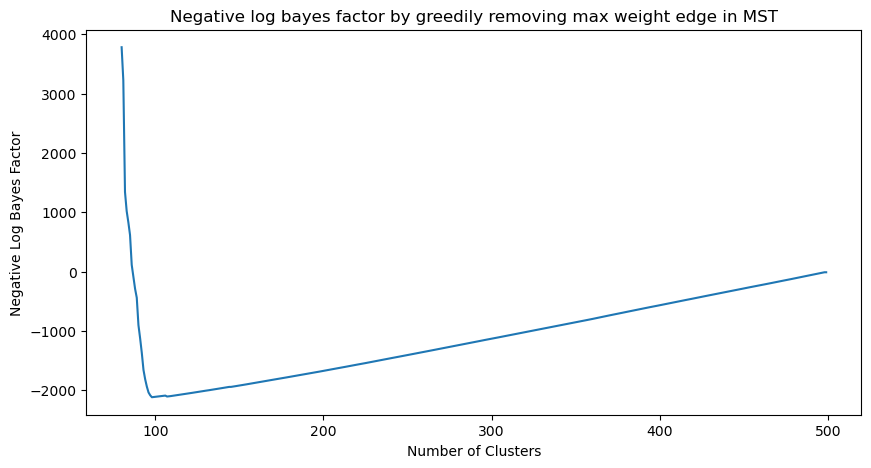

In [10]:
plt.figure(figsize=(10,5))
plt.plot(range(start_cluster,data.shape[0]), bayes)
plt.xlabel("Number of Clusters")
plt.ylabel("Negative Log Bayes Factor")
plt.title("Negative log bayes factor by greedily removing max weight edge in MST")
plt.show()

In [12]:

num_catalog = 100
np.random.seed(42)
num=100
size=30
Qmat=np.empty((1,2))
m = mock(num=num,size=size, seed = 20)
# generate 3 catalogs with sigma=0.1" and different selection intevals
cmat = []
sel_list = []
for i in range(num_catalog): #List of catalogs with coordinates and conditions
    catalog_i, final_sel = cat(m)
    cmat.append(catalog_i)
    sel_list.append(final_sel)

true_matching_dict = {}
count_list = [0]*num_catalog
for source_index in range(num):
    index_list = []
    for catalog_index in range(num_catalog):
        if sel_list[catalog_index][source_index] == True:
            index_list.append((catalog_index, count_list[catalog_index]))
            count_list[catalog_index]+=1
    true_matching_dict[source_index] = index_list

In [15]:
import random
import string
import math
import time 
import itertools
from math import log as ln
from math import exp
import pandas as pd
import numpy as np
from gurobipy import *
from scipy import spatial
from scipy import sparse
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

Number of clusters: 93


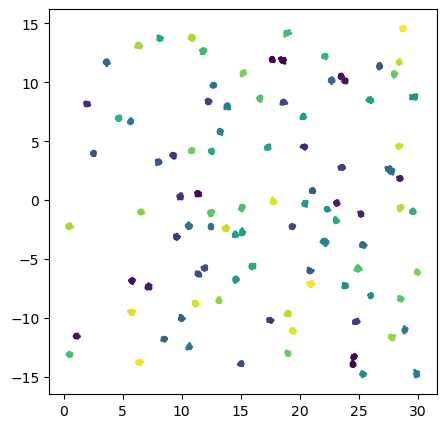

In [16]:
label = []
X = []
for i in range(num_catalog):
    label += [i]*len(cmat[i])
    first_coord, second_coord = cmat[i][:,:2].T
    X += [(i, j) for i, j in zip(first_coord, second_coord)]
label = np.array(label)
X = np.array(X)
sigma_max = 0.1
result = DBSCAN(eps=5*sigma_max, min_samples=2).fit(X)
y_pred = DBSCAN(eps=5*sigma_max, min_samples=2).fit_predict(X)
fig = plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y_pred, s=2.0)
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))

In [13]:
def get_candidate_list(clustering_result, catalog_label, clustering_label):
    candidate_dict = {}
    list_of_label = catalog_label[np.where(clustering_result.labels_==clustering_label)] #The catalog id of all sources found in the island
    for j in np.unique(list_of_label):
        list_of_indices = []
        for k in range(sum(list_of_label==j)):
            list_of_indices.append(((np.where(cmat[j][:,:2]==clustering_result.components_[np.where(clustering_result.labels_==clustering_label)][list_of_label==j][k])[0][0]), j))
        candidate_dict[j] = list_of_indices # catalog id: (source id, catalog id)

    # Get all the (catalog_id, source_id) pairs
    candidate_list = []
    for key in candidate_dict.keys():
        list_of_value = candidate_dict[key]
        for pair in list_of_value:
            candidate_list.append(pair)

    catalog_list = []
    source_list = []
    coord_1_list = []
    coord_2_list = []
    Sigma_list = []
    for catalog_source_pair in candidate_list:
        catalog_list.append(catalog_source_pair[1])
        source_list.append(catalog_source_pair[0])
        coord_1_list.append(cmat[catalog_source_pair[1]][catalog_source_pair[0]][0])
        coord_2_list.append(cmat[catalog_source_pair[1]][catalog_source_pair[0]][1])
        Sigma_list.append(cmat[catalog_source_pair[1]][catalog_source_pair[0]][2])
    df = pd.DataFrame({'Catalog_id': catalog_list, 'Source_id': source_list, 'Coordinate_1': coord_1_list, 'Coordinate_2': coord_2_list}) #Make a dataframe from the information provided
    return(candidate_list, df, catalog_list, Sigma_list)

def get_distance(list_of_indexes, df):
    '''
    Given 2 pairs of (source_index, catalog_index), return the square distance between them
    df has the columns ('Catalog id', 'Source id', Coord 1, Coord 2)
    '''
    coord_list = []
    for i in range(2):
        coord_list+=[np.array(df[(df['Catalog_id'] == list_of_indexes[i][1]) & (df['Source_id'] == list_of_indexes[i][0])].iloc[:,-2:])[0]]
    array_matrix = np.array(coord_list)
    return(np.linalg.norm(array_matrix[1]-array_matrix[0])**2)

def get_distance_2(list_of_indexes, coord_dict):
    '''
    Given 2 pairs of (source_index, catalog_index), return the square distance between them
    df has the columns ('Catalog id', 'Source id', Coord 1, Coord 2)
    '''
    c1 = coord_dict[list_of_indexes[0]]
    c2 = coord_dict[list_of_indexes[1]]
    
    return ((c1[0] - c2[0]) ** 2) + ((c1[1] - c2[1]) ** 2)

def sum_of_distance(list_of_objects, df):
    '''
    Given n pairs of (catalog_index, source_index), return the sum of all pairwise square distance.
    '''
    num_of_objects = len(list_of_objects)
    coord_list = []
    for i in range(num_of_objects):
        coord_list+=[np.array(df[(df['Catalog_id'] == list_of_objects[i][1]) & (df['Source_id'] == list_of_objects[i][0])].iloc[:,-2:])[0]]
    array_matrix = np.array(coord_list)
    pairwise_dist = spatial.distance.pdist(np.array(array_matrix))**2
    sum_of_square_dist = sum(pairwise_dist)
    return sum_of_square_dist

def Bayes_factor(list_of_objects, coord_dict):
    '''
    Compute -ln B_o
    '''
    sum_ln_kappa_rad = 0
    kappa_rad_sum = 0
    kappa_sum = 0
    neg_ln_Bayes = 0
    num_of_objects = len(list_of_objects)
    
    for tup in list_of_objects:
        sum_ln_kappa_rad += ln(kappa_rad_dict[tup])
        kappa_rad_sum += kappa_rad_dict[tup]
        kappa_sum += kappa_dict[tup]
    
    double_sum = 0
    
    for index_1 in range(num_of_objects):
        for index_2 in range(index_1+1,num_of_objects):
            double_sum += kappa_dict[list_of_objects[index_1]]*kappa_dict[list_of_objects[index_2]]*get_distance_2([list_of_objects[index_1],list_of_objects[index_2]],coord_dict)
    
    double_sum *= (1/(4*kappa_sum))
    
    neg_ln_Bayes = double_sum + (1 - num_of_objects)*ln(2) - sum_ln_kappa_rad + ln(kappa_rad_sum)
    return neg_ln_Bayes

def compute_distance_dictionary(list_of_indices, df):
    '''
    Return a dictionary with the form: dict[('Source_id_1', 'Catalog_id_1'), ('Source_id_2', 'Catalog_id_2')] = square distance between them. 
    '''
    distance_dict = {}
    for current_pair_index in range(len(list_of_indices)):
        for next_pair_index in range(current_pair_index + 1, len(list_of_indices)):
            if list_of_indices[next_pair_index][1]!= list_of_indices[current_pair_index][1]: # Only find distances for sources from different catalogs
                distance_dict[(list_of_indices[current_pair_index],list_of_indices[next_pair_index])] = get_distance([list_of_indices[current_pair_index],list_of_indices[next_pair_index]], df)
    return distance_dict

def compute_distance_dictionary_2(list_of_indices, coord_dict):
    '''
    Return a dictionary with the form: dict[('Source_id_1', 'Catalog_id_1'), ('Source_id_2', 'Catalog_id_2')] = square distance between them. 
    '''
    distance_dict = {}
    for current_pair_index in range(len(list_of_indices)):
        for next_pair_index in range(current_pair_index + 1, len(list_of_indices)):
            if list_of_indices[next_pair_index][1]!= list_of_indices[current_pair_index][1]: # Only find distances for sources from different catalogs
                distance_dict[(list_of_indices[current_pair_index],list_of_indices[next_pair_index])] = get_distance_2([list_of_indices[current_pair_index],list_of_indices[next_pair_index]], coord_dict)
    return distance_dict

In [17]:
# Get a particular island to run the matching procedure
cluster_num = 43
# cluster_num = 44
candidate_list, df, catalog_list, Sigma_list = get_candidate_list(result, label, cluster_num)

coord_dict = {(row[1],row[0]): (row[2],row[3]) for row in df.itertuples(index=False, name=None)}

# detection_total = len(candidate_list) #Total number of sources across different catalogs
detection_total = 2
# detection_total = 5

kappa_dict = {}
kappa_rad_dict = {}
ln_kappa_rad_dict = {}

# DEBUG: For testing, set all equal kappa
# for i in range(len(Sigma_list)):
#     Sigma_list[i] = 0.05

for i in range(len(candidate_list)):
    kappa_dict[(candidate_list[i][0], candidate_list[i][1])] = 1/(Sigma_list[i])**2 #in arcsecond 
    kappa_rad_dict[(candidate_list[i][0], candidate_list[i][1])] = 1/((Sigma_list[i]*np.pi/180/3600)**2) #in radian
    ln_kappa_rad_dict[(candidate_list[i][0], candidate_list[i][1])] = ln(1/((Sigma_list[i]*np.pi/180/3600)**2))
    
sigma_min = min(Sigma_list)
sigma_max = max(Sigma_list)

# Used for clustering methods
df2 = df.copy()
kappa_rad_list = []
cat_tups = []

for row in df2.itertuples():
    cat_id = row.Catalog_id
    source_id = row.Source_id
    cat_tups.append((source_id, cat_id))
    kappa_rad = kappa_rad_dict[(source_id,cat_id)]
    kappa_rad_list.append(kappa_rad)

df2["kappa_rad"] = kappa_rad_list

In [20]:
def neg_log_bayes_from_obj_dict(obj_dict, coord_dict):
    """
    Calculate the total negative log bayes factor
    from a dictionary of object lists.
    """
    neg_log_bayes = 0
    for obj_num, tup_list in obj_dict.items():
        neg_log_bayes += Bayes_factor(tup_list, coord_dict)
    return neg_log_bayes

In [25]:
from sklearn.cluster import KMeans
from tqdm import tqdm
from collections import defaultdict

from cop_kmeans import cop_kmeans

# Create cannot-links (list of tuples)
catalog_groups = defaultdict(list)
for t in cat_tups:
    catalog_groups[t[1]].append(t)
    
X = np.zeros((len(coord_dict), 2))
sample_weights = np.zeros(len(coord_dict))

tup_dict = dict()

cannot_link_dict: dict[int,list[int]] = defaultdict(list)
for i, (t, coord) in enumerate(coord_dict.items()):
    cannot_link_dict[t[1]].append(i)
    X[i,:] = coord
    sample_weights[i] = kappa_dict[t]
    tup_dict[i] = t

import itertools

cannot_link = []

for l in cannot_link_dict.values():
    for comb in itertools.combinations(l,2):
        cannot_link.append(comb)
    
bayes_list = []
k_list = []
best_cop_obj_dict = dict()
best_b = np.inf
k = 2
clusters, centers = cop_kmeans(dataset=X, initialization="kmpp", k=k, ml=[],cl=cannot_link, sample_weights=sample_weights)

obj_dict = defaultdict(list)
for c,t in zip(clusters, cat_tups):
    obj_dict[c].append(t)

b = neg_log_bayes_from_obj_dict(obj_dict, coord_dict)
if b < best_b:
    best_b = b
    best_cop_obj_dict = obj_dict
bayes_list.append(b)
k_list.append(k)

In [34]:
label_dict = dict()
for label, tup_list in best_cop_obj_dict.items():
    for t in tup_list:
        label_dict[t] = label

In [66]:
scores = dict()

for label, tup_list in best_cop_obj_dict.items():
    other_label = 0
    if label == 0:
        other_label = 1
        
    for tup in tup_list:
        coord = coord_dict[tup]
        assigned_dist = (((centers[label][0] - coord[0]) ** 2) + ((centers[label][1] - coord[1]) ** 2)) ** 0.5
        other_dist = (((centers[other_label][0] - coord[0]) ** 2) + ((centers[other_label][1] - coord[1]) ** 2)) ** 0.5
        scores[tup] = (other_dist / assigned_dist)

In [67]:
scores

{(44, 0): 1.5007752776016403,
 (44, 1): 2.81964358010189,
 (44, 2): 1.5280679328847329,
 (44, 3): 2.341903194777404,
 (44, 4): 1.9942464865599956,
 (44, 5): 1.255880723935617,
 (44, 6): 4.6521886870942595,
 (44, 7): 4.203417600453279,
 (44, 8): 3.715116334276326,
 (44, 9): 1.9539515899787148,
 (92, 10): 0.5279001169249566,
 (44, 11): 1.2615410085385126,
 (44, 12): 2.178188160886322,
 (44, 13): 1.1423204507726072,
 (44, 14): 2.644687209421707,
 (44, 15): 4.36223352690703,
 (44, 16): 5.928922378112986,
 (44, 17): 1.8948705462230886,
 (44, 18): 3.285933596385278,
 (44, 19): 5.979155052197475,
 (44, 20): 6.546582776247143,
 (44, 21): 3.336037894665364,
 (44, 22): 1.575532069110431,
 (44, 23): 2.3580862137150715,
 (44, 24): 2.481823193044888,
 (44, 25): 19.04820761036979,
 (44, 26): 2.301877241794756,
 (44, 27): 14.817654223874943,
 (44, 28): 1.3727464066238744,
 (92, 29): 0.3439285374342542,
 (44, 30): 4.070250671371403,
 (44, 31): 3.255520722614776,
 (44, 32): 2.6472197183829214,
 (44, 33

In [79]:
assigned_tups = set()

for c in range(num_catalog):
    t1 = (44,c)
    t2 = (92,c)
    tol = 2.9
    if scores[t1] > tol and scores[t2] > tol:
        print(label_dict[t1], label_dict[t2])
        assigned_tups.add(t1)
        assigned_tups.add(t2)

1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0


In [80]:
assigned_tups

{(44, 6),
 (44, 8),
 (44, 15),
 (44, 25),
 (44, 34),
 (44, 39),
 (44, 53),
 (44, 61),
 (44, 72),
 (44, 75),
 (44, 81),
 (44, 86),
 (44, 95),
 (92, 6),
 (92, 8),
 (92, 15),
 (92, 25),
 (92, 34),
 (92, 39),
 (92, 53),
 (92, 61),
 (92, 72),
 (92, 75),
 (92, 81),
 (92, 86),
 (92, 95)}